# **Mall Customer Clustering**

In [115]:
%%HTML
<style>
    body {
        --vscode-font-family: "KoddiUD 온고딕"
    }
</style>

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
# 상관 계수 계산
corr_matrix = numeric_df.corr()

# 히트맵 그리기
fig = px.imshow(corr_matrix, color_continuous_scale='ylorrd', 
                labels=dict(color="Correlation"),
                title="Correlation Heatmap")
fig.update_layout(
    xaxis_tickangle=-45,  # x축 라벨 회전
    yaxis_tickangle=-45,  # y축 라벨 회전
    xaxis_tickfont=dict(size=7),  # x축 라벨 크기 조정
    yaxis_tickfont=dict(size=7)
)
fig.show()

In [116]:
import numpy as np
import pandas as pd
import missingno

import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

import warnings
warnings.filterwarnings('ignore')

- 데이터 출처
  - [Kaggle-Mall Customer Segment Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)
- 데이터 명세

## 데이터 살펴보기 & 전처리

In [117]:
df = pd.read_csv('Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [118]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


- max와 min의 차이가 심함

### 결측치

<Axes: >

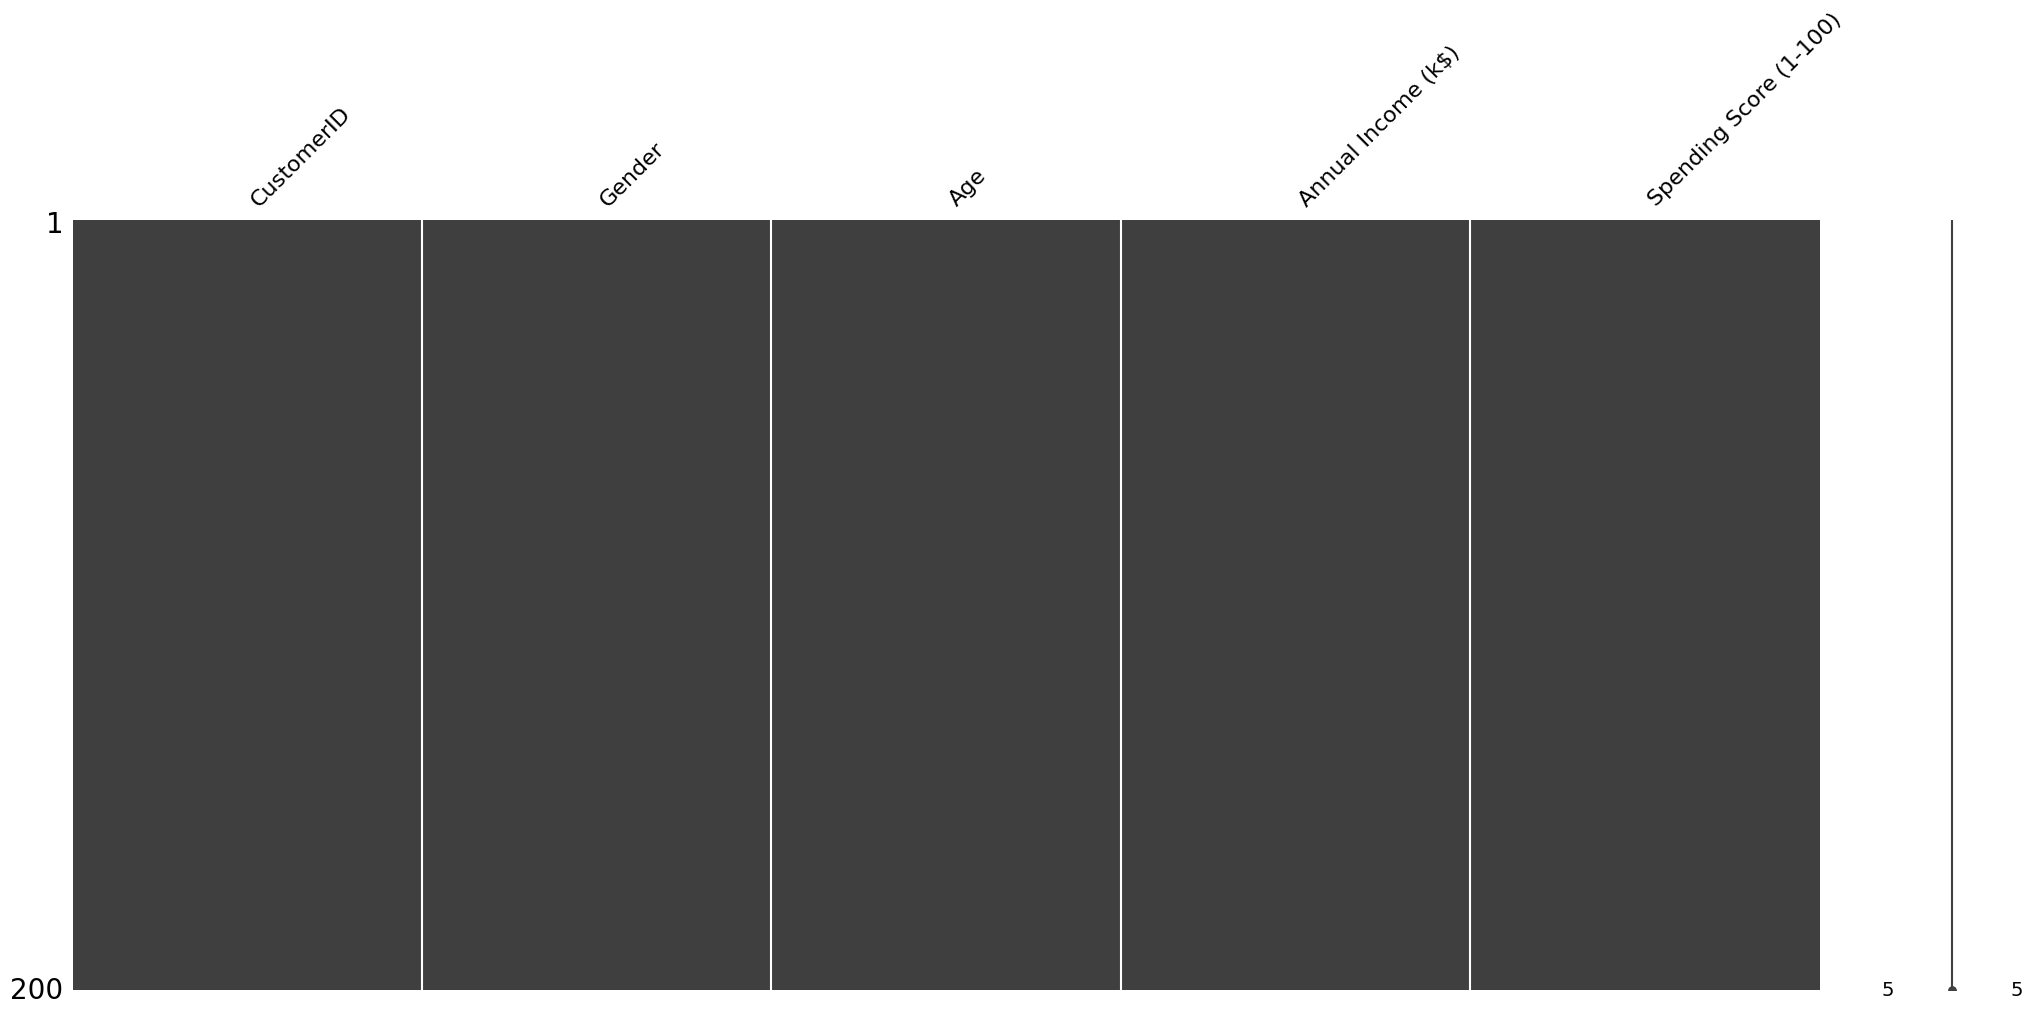

In [119]:
missingno.matrix(df)

## **EDA**

### Gender

In [120]:
fig = px.pie(df, names='Gender', values='CustomerID')
fig.show()  # 보통 원 그래프를 통해 상대빈도 값을 확인

### Age

In [121]:
fig = px.histogram(df, x='Age', nbins=10)
fig.show()

In [122]:
df_age=df.groupby('Age').count()

In [123]:
df_age.head()

,CustomerID,Gender,Annual Income (k$),Spending Score (1-100)
Age,,,,
18,4,4,4,4
19,8,8,8,8
20,5,5,5,5
21,5,5,5,5
22,3,3,3,3


In [124]:
fig = px.bar(df_age, x=df_age.index, y='CustomerID', title='Customer Count by Age',
             labels={'CustomerID': 'Count', 'index': 'Age'})
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis=dict(dtick=1),
    template='ggplot2'
)
fig.show()

### Spending Score (1-100)

In [125]:
fig = px.histogram(df, x='Spending Score (1-100)', nbins=20)
fig.show()

### 전체 경향성 살펴보기

In [126]:
fig = px.scatter_matrix(df,
    dimensions=['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    title='Scatter Matrix of Customer Data',
    labels={'Annual Income (k$)': 'Annual Income (k$)', 'Spending Score (1-100)': 'Spending Score'}
)

fig.update_traces(diagonal_visible=True)  # 대각선의 그래프 표시
fig.update_layout(
    width=1000, height=1000
)

fig.show()


- Annual Income과 Spending Score 간 그룹핑이 되어가는 모습을 볼 수 있음

### 상관관계

In [127]:
numeric_df = df.select_dtypes(include=[np.number])
# 상관 계수 계산
corr_matrix = numeric_df.corr()

# 히트맵 그리기
fig = px.imshow(corr_matrix, color_continuous_scale='ylorrd', 
                labels=dict(color="Correlation"),
                title="Correlation Heatmap")
fig.show()

- Annual Income과 Customer ID 
  - 돈 많이 버는 사람의 ID가 뒷 번호에 있음

In [128]:
fig = px.violin(df, y='Spending Score (1-100)', color='Gender', box=True, 
                 title='Spending Score by Gender', 
                 labels={'Spending Score (1-100)': 'Spending Score', 'Gender': 'Gender'})
fig.update_traces(meanline_visible=True)
fig.show()


- 여성이 살짝 더 높음

In [129]:
fig = px.violin(df, y='Annual Income (k$)', color='Gender', box=True, 
                 title='Annual Income by Gender', 
                 labels={'Annual Income (k$)': 'Annual Income', 'Gender': 'Gender'})
fig.update_traces(meanline_visible=True)
fig.show()

- 남성 연봉이 조금 더 높음

## 클러스터링

### 적합한 inerita 개수

In [130]:
df_income_score = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()

In [131]:
ks = range(1,10)
inertias = []

for k in ks:
  model = KMeans(n_clusters=k, init='k-means++', random_state=1)
  model.fit(df_income_score)
  inertias.append(model.inertia_)

# ks와 inertias 데이터를 DataFrame으로 변환
data = pd.DataFrame({'k': ks, 'Inertia': inertias})

# 선 그래프 그리기
fig = px.line(data, x='k', y='Inertia', title='Inertia vs. Number of Clusters (k)',
              markers=True)  # markers=True로 점 표시

fig.show()

### K-Means++ 모델링

In [132]:
model = KMeans(n_clusters=5, init='k-means++', random_state=1)
y_means = model.fit_predict(df_income_score)

# 클러스터 레이블을 DataFrame에 추가
df_income_score['Cluster'] = y_means

# 산점도 그리기
fig = px.scatter(df_income_score, 
                 x='Annual Income (k$)', 
                 y='Spending Score (1-100)', 
                 color='Cluster', 
                 title='KMeans Clustering of Income and Spending Score',
                 color_continuous_scale=px.colors.sequential.Plotly3)  # 색상 스케일 지정

fig.show()

### Hierarchical Clustering(계층적 군집)

In [133]:
model = AgglomerativeClustering(n_clusters=5)
y_means = model.fit_predict(df_income_score)

df_income_score['Cluster'] = y_means

# 산점도 그리기
fig = px.scatter(df_income_score, 
                 x='Annual Income (k$)', 
                 y='Spending Score (1-100)', 
                 color='Cluster', 
                 title='Agglomerative Clustering of Income and Spending Score',
                 color_continuous_scale=px.colors.sequential.Plotly3)  # 색상 스케일 지정

fig.show()

### DBSCAN(밀도 기반 군집화)

In [134]:
model = DBSCAN(eps=5, min_samples=5)
y_means = model.fit_predict(df_income_score)

# 클러스터 레이블을 DataFrame에 추가
df_income_score['Cluster'] = y_means

# 산점도 그리기
fig = px.scatter(df_income_score, 
                 x='Annual Income (k$)', 
                 y='Spending Score (1-100)', 
                 color='Cluster', 
                 title='DBSCAN Clustering of Income and Spending Score',
                 color_discrete_sequence=px.colors.qualitative.Plotly)  # 색상 스케일 지정

fig.show()

### Spectral Clustering

In [135]:
model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=1)
y_means = model.fit_predict(df_income_score)

# 클러스터 레이블을 DataFrame에 추가
df_income_score['Cluster'] = y_means

# 산점도 그리기
fig = px.scatter(df_income_score, 
                 x='Annual Income (k$)', 
                 y='Spending Score (1-100)', 
                 color='Cluster', 
                 title='Spectral Clustering of Income and Spending Score',
                 color_discrete_sequence=px.colors.qualitative.Set1)  # 색상 스케일 지정

fig.show()

- KMeans와 유사